# Multi Photopeak Reconstruction

In [1]:
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.utils import print_collimator_parameters
from pytomography.projectors import ExtendedSystemMatrix
import pytomography
import matplotlib.pyplot as plt
import pydicom
import torch
import shutil

Change this to the path where you downloaded the PyTomography tutorial data

In [2]:
PATH = '/mnt/mydisk2/pytomo_tutorial_data/SPECT'

In [3]:
path = os.path.join(PATH, 'Lu177-NEMA-SymT2')
path_CT = os.path.join(path, 'CT')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
file_NM = os.path.join(path, 'projection_data.dcm')

The idea behind dual peak reconstruction is that we will construct two seperate system matrices (one for each peak) and then combine them together. Most of this is similar to the standard DICOM tutorial, but now we're constructing two different system matrices

In [4]:
dicom.print_energy_window_info(file_NM)

Index 0:   Name: "Window Group A", Energies: [187.19999694824keV, 228.80000305176keV]
Index 1:   Name: "Window Group B", Energies: [166.39999389648keV, 187.19999694824keV]
Index 2:   Name: "Window Group C", Energies: [228.80000305176keV, 249.60000610352keV]
Index 3:   Name: "Window Group D", Energies: [101.69999694824keV, 124.30000305176keV]
Index 4:   Name: "Window Group E", Energies: [85.879997253418keV, 101.69999694824keV]
Index 5:   Name: "Window Group F", Energies: [124.30000305176keV, 146.89999389648keV]


In [5]:
object_meta, proj_meta = dicom.get_metadata(file_NM)
photopeak208 = dicom.get_projections(file_NM, index_peak=0)
photopeak113 = dicom.get_projections(file_NM, index_peak=3)
scatter208 = dicom.get_energy_window_scatter_estimate(file_NM, index_peak=0, index_lower=1, index_upper=2)
scatter113 = dicom.get_energy_window_scatter_estimate(file_NM, index_peak=3, index_lower=4, index_upper=5)
amap208 = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=0)
amap113 = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=3)
collimator_name = 'SY-ME'
intrinsic_resolution=0.38 #mm at 140 keV
psf_meta208 = dicom.get_psfmeta_from_scanner_params(
    collimator_name,
    energy_keV =  208,
    intrinsic_resolution_140keV=intrinsic_resolution
)
psf_meta113 = dicom.get_psfmeta_from_scanner_params(
    collimator_name,
    energy_keV = 113,
    intrinsic_resolution_140keV=intrinsic_resolution
)
att_transform208 = SPECTAttenuationTransform(attenuation_map=amap208)
att_transform113 = SPECTAttenuationTransform(attenuation_map=amap113)
psf_transform208 = SPECTPSFTransform(psf_meta=psf_meta208)
psf_transform113 = SPECTPSFTransform(psf_meta=psf_meta113)
system_matrix208 = SPECTSystemMatrix(
    obj2obj_transforms=[att_transform208, psf_transform208],
    proj2proj_transforms=[],
    object_meta=object_meta,
    proj_meta=proj_meta,
)
system_matrix113 = SPECTSystemMatrix(
    obj2obj_transforms=[att_transform113, psf_transform113],
    proj2proj_transforms=[],
    object_meta=object_meta,
    proj_meta=proj_meta,
)

Given photopeak energy 208.0 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2
Given photopeak energy 113.0 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 113.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2


From these two system matrices, we build a single system matrix that simulatenously projects to both peaks at once

* The system matrices need to be scaled by the relative calibration factor in CPS/MBq in order to compensate for differnces in count rate between the two peaks

In [6]:
# These calibration factors are approximate and come from SIMIND
calib208 = 10.2419 # CPS/MBq
calib113 = 11.3 # CPS/MBq

system_matrix = ExtendedSystemMatrix(
    system_matrices= [
        calib113*system_matrix113,
        calib208*system_matrix208
    ] 
)

Now if we create an object and forward project, it will project to both peaks

In [7]:
test_object = torch.zeros((128,128,128)).to(pytomography.device)
test_object[50:70,50:70,50:70] = 1

In [8]:
test_projections = system_matrix.forward(test_object)
test_projections.shape

torch.Size([2, 96, 128, 128])

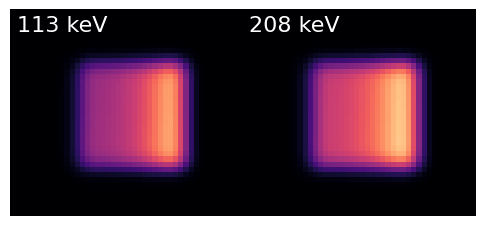

In [9]:
IDX_113 = 0
IDX_208 = 1
test_projection_113 = test_projections[IDX_113][25].cpu().T
test_projection_208 = test_projections[IDX_208][25].cpu().T
fig, ax = plt.subplots(1,2, figsize=(6,3), gridspec_kw={'wspace':0.0})
ax[0].imshow(test_projection_113, cmap='magma', vmax=80)
ax[0].set_xlim(45,90)
ax[0].set_ylim(40,80)
ax[0].axis('off')
ax[0].text(0.03, 0.97, '113 keV', color='white', transform=ax[0].transAxes, ha='left', va='top', fontsize=16)
ax[1].imshow(test_projection_208, cmap='magma', vmax=80)
ax[1].set_xlim(45,90)
ax[1].set_ylim(40,80)
ax[1].axis('off')
ax[1].text(0.03, 0.97, '208 keV', color='white', transform=ax[1].transAxes, ha='left', va='top', fontsize=16)
plt.show()

We can create the likelihood by stacking the photopeak/scatters as well

In [10]:
photopeak = torch.stack([photopeak113, photopeak208], dim=0)
scatter = torch.stack([scatter113, scatter208], dim=0)
likelihood = PoissonLogLikelihood(system_matrix, photopeak, scatter)

Then we reconstruct as normal:

In [11]:
recon_algo = OSEM(likelihood)
recon_OSEM = recon_algo(n_iters = 8, n_subsets=8)

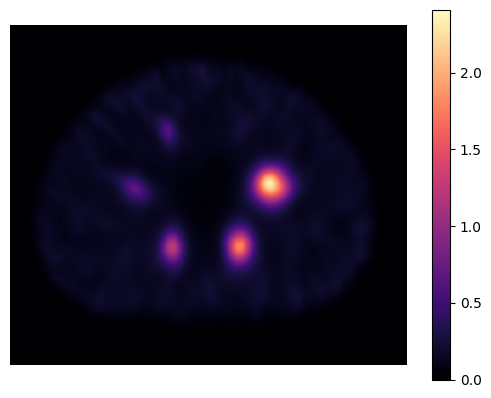

In [12]:
plt.imshow(recon_OSEM[:,:,61].cpu().T, cmap='magma', interpolation='gaussian')
plt.xlim(30,100)
plt.ylim(100,40)
plt.axis('off')
plt.colorbar()
plt.show()

You may wonder what the units are above. Since we scaled the system matrix by factors with units of Counts / second / MBq, the image has units of MBq $\cdot$ seconds. Why?:
* Image $\times$ system matrix = projections and projecitons have units of counts

So we can convert our image to units of MBq by diving by time, which in this case is the measured time per projection (15s):

In [13]:
pydicom.dcmread(file_NM).RotationInformationSequence[0].ActualFrameDuration / 1000

15.002